In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/bootcamp/Averiguacao Cadastral/

/content/drive/MyDrive/bootcamp/Averiguacao Cadastral


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [7]:
# Load the datasets
df_familia_pessoa = pd.read_csv('bases/df_fam_pessoas_amostra_100mil.csv', sep=',')
df_familia_pessoas_tratado = pd.read_csv('bases/df_tratado.csv').drop(['qtd_comodos_domic_fam', 'qtd_comodos_dormitorio_fam','classe_renda'], axis=1)
df_familia_pessoas_final = df_familia_pessoa.merge(df_familia_pessoas_tratado, on='id_familia', how='left')
df_familia_pessoas_final = df_familia_pessoas_final.sample(10000)

In [8]:
colunas_duplicadas = df_familia_pessoas_final.columns[df_familia_pessoas_final.columns.duplicated()]

print("Atributos duplicados:")
print(colunas_duplicadas)

Atributos duplicados:
Index([], dtype='object')


In [9]:
df_familia_pessoas_final = df_familia_pessoas_final[['uf_ibge','idade','qtde_pessoas', 'qtd_meses_12_meses_memb',
                                                     'tem_idoso', 'chefe_conta_propria', 'cod_deficiencia_memb',
                                                      'dias_cadastramento', 'classe_renda']]

In [10]:
#for coluna in df_familia_pessoas_final.columns:
#    print(f"Atributo: {coluna}")

In [11]:
# Selecionando as variáveis que serão utilizadas para o modelo
X = df_familia_pessoas_final.drop('classe_renda', axis=1)

#X = df_familia_pessoas_final [['qtd_pessoas', 'idade',
#                               'cod_principal_trab_memb', 'trabalho_principal','cod_deficiencia_memb','qtd_meses_12_meses_memb']]

y = df_familia_pessoas_final['classe_renda']

# Exibindo as informações de X
print('X =', X.shape)
X.head()

X = (10000, 8)


,uf_ibge,idade,qtde_pessoas,qtd_meses_12_meses_memb,tem_idoso,chefe_conta_propria,cod_deficiencia_memb,dias_cadastramento
146138,21,39,3,6.0,0.0,0,2,4087.0
187978,23,25,1,-1.0,0.0,0,2,2484.0
226299,52,32,5,4.0,0.0,0,2,437.0
27512,51,17,3,-1.0,0.0,1,2,2084.0
249419,15,26,5,-1.0,0.0,0,2,2138.0


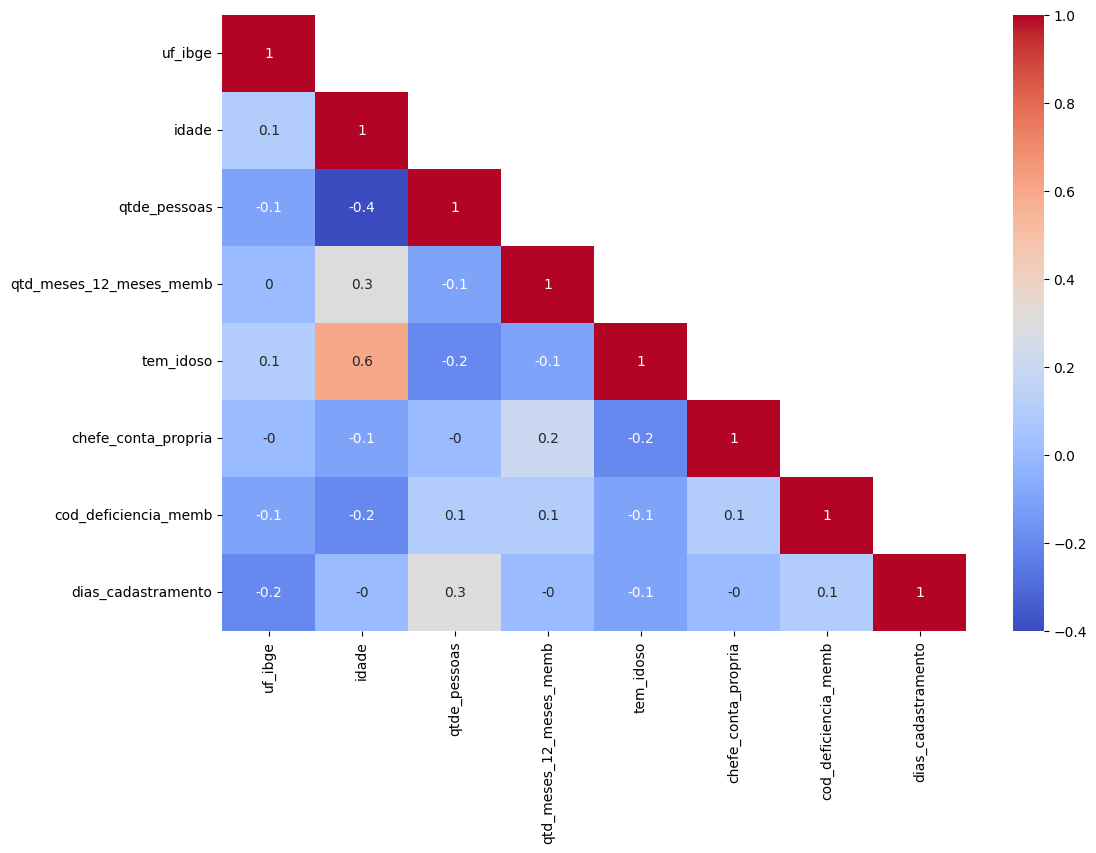

In [12]:
# Cria mask para não mostrar valores acima da diagonal
mask = np.triu(np.ones_like(X.corr(), dtype=bool), k=1)

plt.figure(figsize=(12,8))
sns.heatmap(X.corr().round(1), annot=True, cmap='coolwarm', mask=mask)
plt.show()

In [13]:
X.columns

Index(['uf_ibge', 'idade', 'qtde_pessoas', 'qtd_meses_12_meses_memb',
       'tem_idoso', 'chefe_conta_propria', 'cod_deficiencia_memb',
       'dias_cadastramento'],
      dtype='object')

In [14]:
X.isnull().sum()

,0
uf_ibge,0
idade,0
qtde_pessoas,0
qtd_meses_12_meses_memb,0
tem_idoso,0
chefe_conta_propria,0
cod_deficiencia_memb,0
dias_cadastramento,0


In [15]:
y.describe()

,classe_renda
count,10000.000000
mean,0.478300
std,0.704542
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [16]:
y.value_counts()

,count
classe_renda,
0.0,6451
1.0,2315
2.0,1234


In [17]:
y.isnull().sum()

0

In [18]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
y_train.describe()

,classe_renda
count,8000.000000
mean,0.478250
std,0.704513
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [20]:
# Mapeando y_train e y_test se necessário (exemplo)
y_train_mapped = y_train.astype('int')
y_test_mapped = y_test.astype('int')

In [21]:
y_train_mapped.describe()

,classe_renda
count,8000.000000
mean,0.478250
std,0.704513
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


# Fazendo um pipeline comparando diversos modelos

In [22]:
!pip install xgboost -q

In [23]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.1 MB/s eta 0:00:00


In [24]:
# Importações necessárias
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 1. Definição dos Modelos

In [25]:
# Definir os modelos e os parâmetros
models = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'classifier__max_depth': [3, 5, 7],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 10, 20]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(objective='multi:softmax', num_class=3, random_state=42),
        'param_grid': {
            'classifier__n_estimators': [250, 300],
            'classifier__max_depth': [3, 5],
            'classifier__learning_rate': [0.1]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(silent=True),
        'param_grid': {
            'classifier__iterations': [250, 500],
            'classifier__depth': [3, 5],
            'classifier__learning_rate': [0.1]
        }
    }
}

# 2. Treinamento e Busca de Hiperparâmetros

In [26]:
# Criar um dicionário para armazenar os melhores modelos
best_models = {}

for model_name, model_info in models.items():
    # Criar o pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model_info['model'])
    ])

    # Definir GridSearchCV
    grid_search = GridSearchCV(pipeline, model_info['param_grid'], cv=3, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train, y_train_mapped)

    # Armazenar o melhor modelo
    best_models[model_name] = grid_search.best_estimator_
    print(f"Melhores hiperparâmetros para {model_name}: {grid_search.best_params_}")

Melhores hiperparâmetros para DecisionTree: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2}
Melhores hiperparâmetros para RandomForest: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
Melhores hiperparâmetros para XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 250}
Melhores hiperparâmetros para CatBoost: {'classifier__depth': 5, 'classifier__iterations': 500, 'classifier__learning_rate': 0.1}


# 3. Avaliação do Modelo

In [27]:
from sklearn.metrics import accuracy_score, f1_score

In [28]:
# Avaliar todos os modelos
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)

    # Calcular F1 Score
    f1 = f1_score(y_test, y_pred, average='macro')

    # Calcular Acurácia
    accuracy = accuracy_score(y_test, y_pred)

    # Exibir os resultados
    print(f"Modelo: {model_name}")
    print(f"  F1 Score: {f1:.2f}")
    print(f"  Acurácia: {accuracy:.2f}")


Modelo: DecisionTree
  F1 Score: 0.60
  Acurácia: 0.74
Modelo: RandomForest
  F1 Score: 0.61
  Acurácia: 0.72
Modelo: XGBoost
  F1 Score: 0.63
  Acurácia: 0.75
Modelo: CatBoost
  F1 Score: 0.63
  Acurácia: 0.75


# 4. Geração de Matriz de Confusão

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

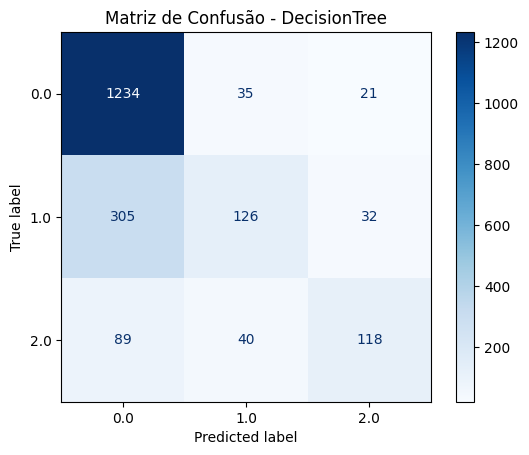

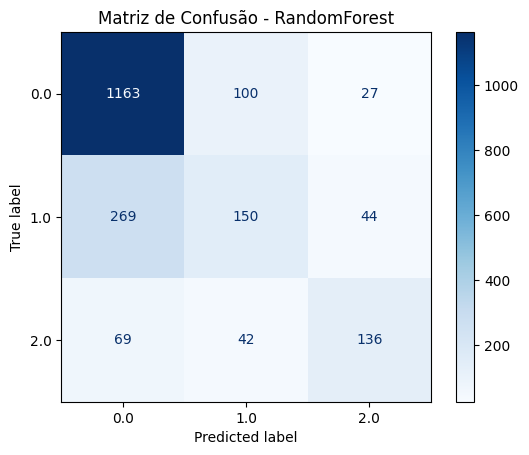

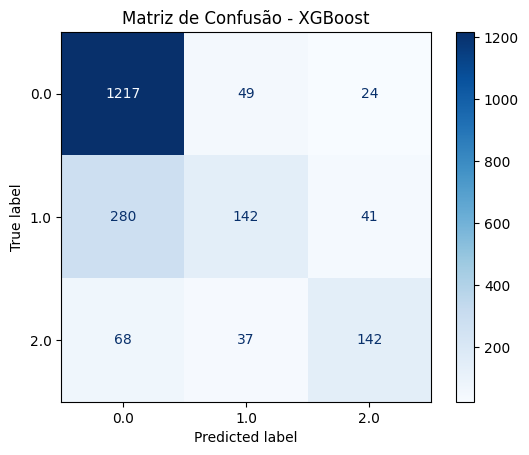

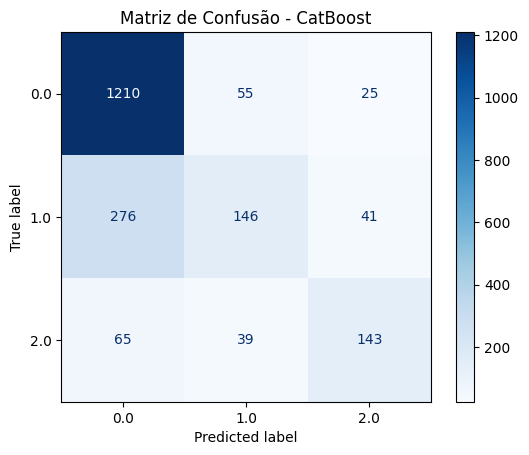

In [30]:
# Gerar matriz de confusão para cada modelo
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()

# 5. Análise da Importância das Features

In [31]:
import numpy as np
from sklearn.inspection import permutation_importance

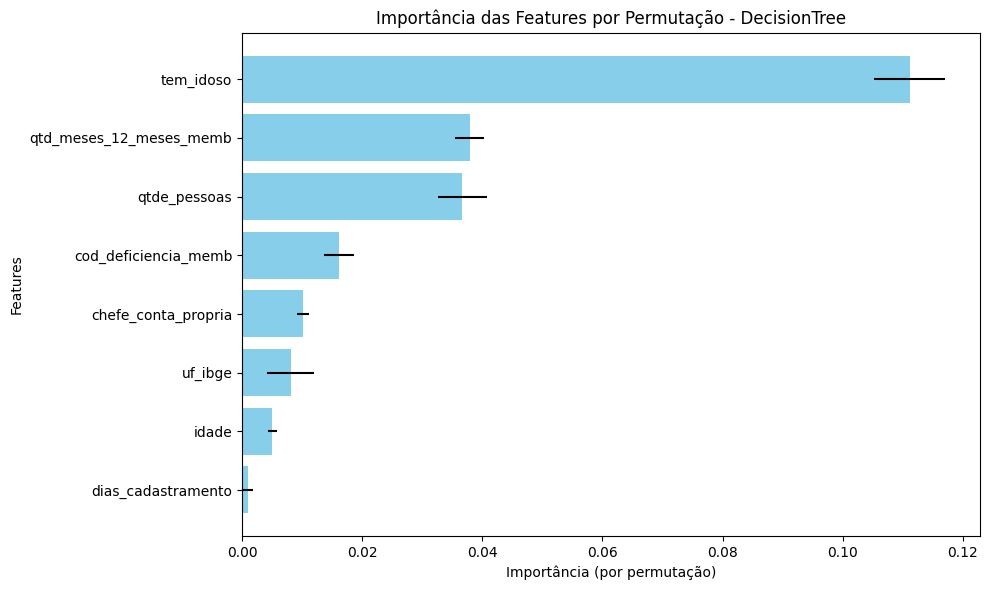

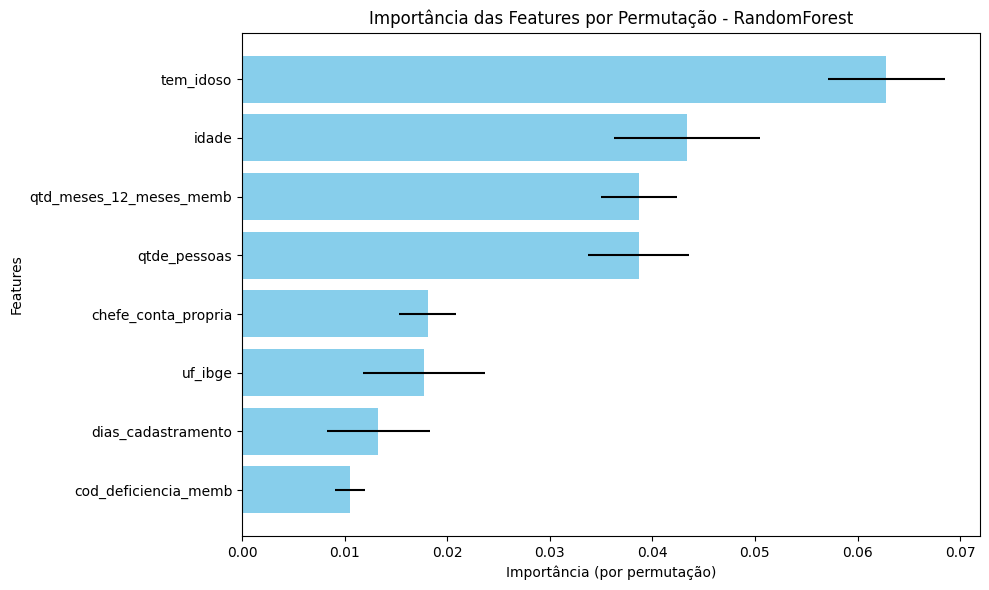

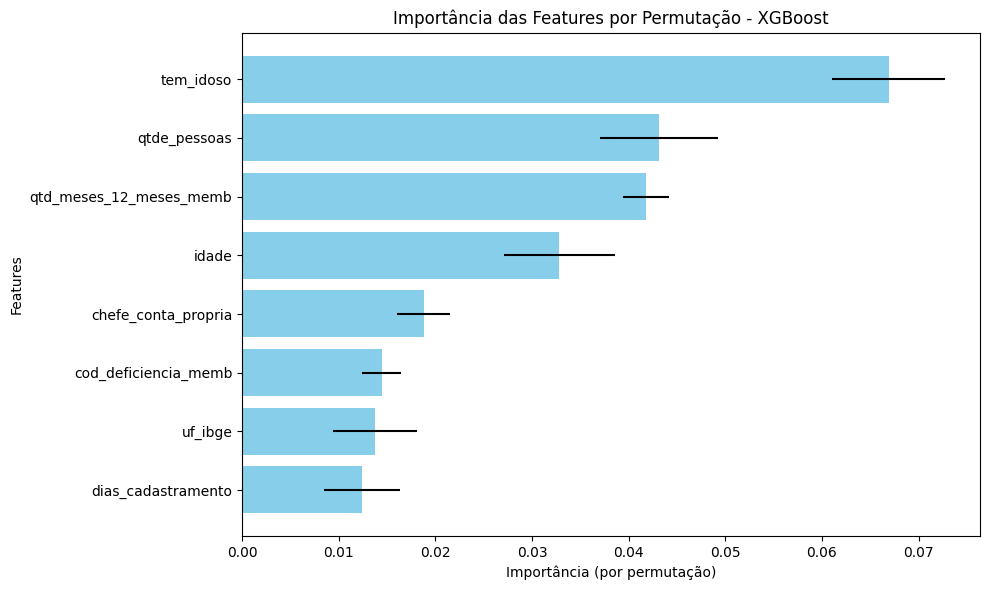

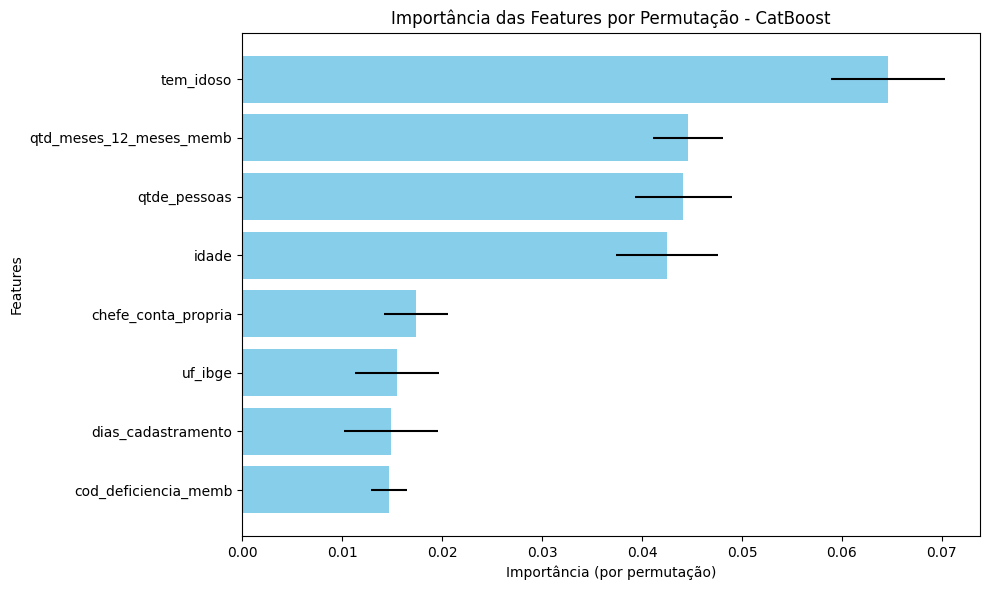

In [32]:
# Importância das features para cada modelo
for model_name, model in best_models.items():
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

    # Ordenar importâncias
    importance_vals = perm_importance.importances_mean
    importance_std = perm_importance.importances_std
    indices = np.argsort(importance_vals)[::-1]

    # Plotar
    plt.figure(figsize=(10, 6))
    plt.title(f"Importância das Features por Permutação - {model_name}")
    plt.barh(range(len(importance_vals)), importance_vals[indices], xerr=importance_std[indices], align="center", color='skyblue')
    plt.yticks(range(len(importance_vals)), X_test.columns[indices])
    plt.gca().invert_yaxis()
    plt.xlabel('Importância (por permutação)')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

In [33]:
# Lista para armazenar as 5 principais features de cada modelo
top_features_list = {}

# Obter as 5 features mais importantes de cada modelo
for model_name, model in best_models.items():
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

    # Extrair valores de importância e índices
    importance_vals = perm_importance.importances_mean
    indices = np.argsort(importance_vals)[::-1]

    # Obter as 5 principais features e suas importâncias
    top_indices = indices[:5]
    top_features = X_test.columns[top_indices]
    top_importances = importance_vals[top_indices]

    # Armazenar em um DataFrame
    top_features_df = pd.DataFrame({
        'Feature': top_features,
        'Importância': top_importances
    })

    # Adicionar ao dicionário
    top_features_list[model_name] = top_features_df

# Exibir as 5 principais features de cada modelo
for model_name, top_features_df in top_features_list.items():
    print(f"\n5 Features mais importantes para o modelo {model_name}:")
    print(top_features_df)


5 Features mais importantes para o modelo DecisionTree:
                   Feature  Importância
0                tem_idoso      0.11115
1  qtd_meses_12_meses_memb      0.03790
2             qtde_pessoas      0.03670
3     cod_deficiencia_memb      0.01615
4      chefe_conta_propria      0.01015

5 Features mais importantes para o modelo RandomForest:
                   Feature  Importância
0                tem_idoso      0.06280
1                    idade      0.04335
2  qtd_meses_12_meses_memb      0.03870
3             qtde_pessoas      0.03865
4      chefe_conta_propria      0.01810

5 Features mais importantes para o modelo XGBoost:
                   Feature  Importância
0                tem_idoso      0.06690
1             qtde_pessoas      0.04315
2  qtd_meses_12_meses_memb      0.04175
3                    idade      0.03285
4      chefe_conta_propria      0.01880

5 Features mais importantes para o modelo CatBoost:
                   Feature  Importância
0                tem_

# Avaliando o balanceamento das classes

In [34]:
# Verificar a distribuição da variável target
target_distribution = y.value_counts(normalize=True)

In [35]:
print("Distribuição da variável target 'classe_renda':")
print(target_distribution)

Distribuição da variável target 'classe_renda':
classe_renda
0.0    0.6451
1.0    0.2315
2.0    0.1234
Name: proportion, dtype: float64


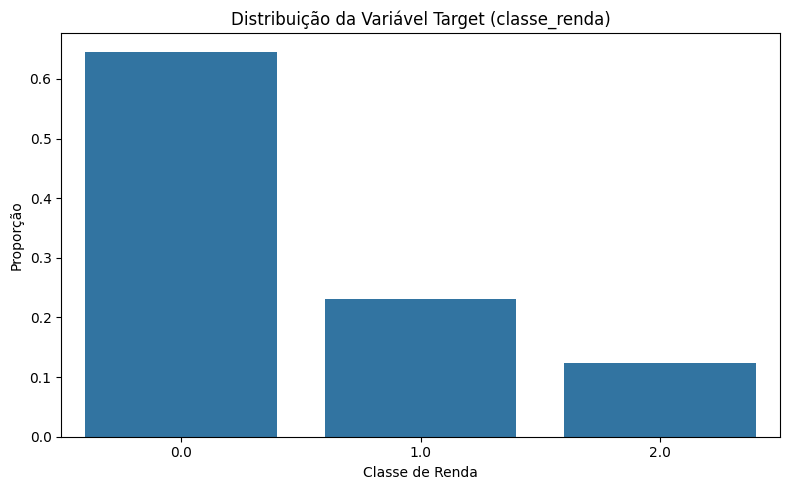

In [36]:
# Plotar a distribuição da variável target
plt.figure(figsize=(8, 5))
sns.barplot(x=target_distribution.index, y=target_distribution.values)
plt.title('Distribuição da Variável Target (classe_renda)')
plt.xlabel('Classe de Renda')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [37]:
# Exibir o número absoluto de ocorrências por classe
absolute_distribution = y.value_counts()

print("\nNúmero absoluto de ocorrências por classe:")
print(absolute_distribution)


Número absoluto de ocorrências por classe:
classe_renda
0.0    6451
1.0    2315
2.0    1234
Name: count, dtype: int64


## Balanceando as classes

In [38]:
pip install imbalanced-learn

In [39]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [40]:
df_familia_pessoas_final.classe_renda.value_counts()

,count
classe_renda,
0.0,6451
1.0,2315
2.0,1234


In [41]:
y.value_counts()

,count
classe_renda,
0.0,6451
1.0,2315
2.0,1234


In [42]:
# Suponha que 'y' seja sua variável alvo e '0.0' seja a classe majoritária
n_samples_majority = y.value_counts()[0.0]

# Oversampling da classe '1.0' para 30% da classe majoritária
n_samples_1 = int(0.9 * n_samples_majority)

# Oversampling da classe '2.0' para 40% da classe majoritária
n_samples_2 = int(0.9 * n_samples_majority)

# Undersampling da classe '0.0' para 70% do tamanho original
n_samples_0 = int(1.0 * n_samples_majority)

over = SMOTE(sampling_strategy={1.0: n_samples_1, 2.0: n_samples_2})
under = RandomUnderSampler(sampling_strategy={0.0: n_samples_0})

In [43]:
# Criar um pipeline que aplica SMOTE e depois o undersampling
pipeline = Pipeline(steps=[('o', over), ('u', under)])

In [44]:
# Aplicar o balanceamento ao conjunto de dados
X_balanced, y_balanced = pipeline.fit_resample(X, y)

In [45]:
# Verificar a nova distribuição das classes
balanced_distribution = pd.Series(y_balanced).value_counts()

print("Distribuição da variável target 'classe_renda' após o balanceamento:")
print(balanced_distribution)

Distribuição da variável target 'classe_renda' após o balanceamento:
classe_renda
0.0    6451
1.0    5805
2.0    5805
Name: count, dtype: int64


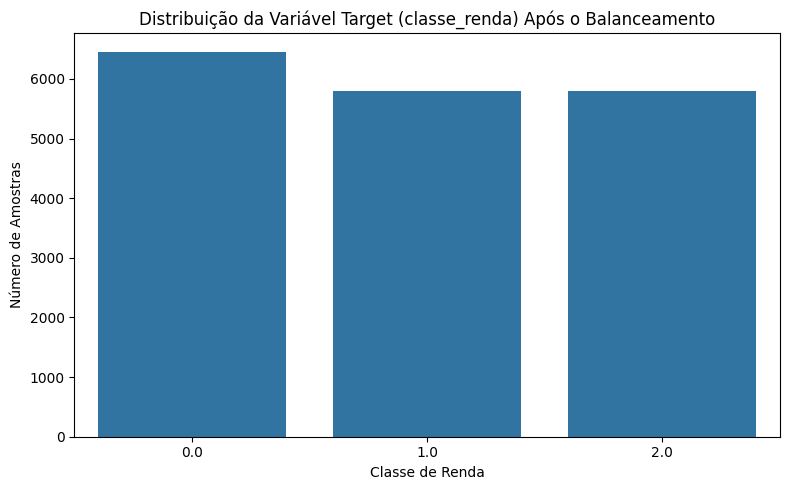

In [46]:
# Visualizar a distribuição das classes após o balanceamento
plt.figure(figsize=(8, 5))
sns.barplot(x=balanced_distribution.index, y=balanced_distribution.values)
plt.title('Distribuição da Variável Target (classe_renda) Após o Balanceamento')
plt.xlabel('Classe de Renda')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Refazendo as análises dos modelos após balanceamento das classes

In [47]:
X_balanced.head()

,uf_ibge,idade,qtde_pessoas,qtd_meses_12_meses_memb,tem_idoso,chefe_conta_propria,cod_deficiencia_memb,dias_cadastramento
5905,24,13,2,-1.0,0.0,0,2,5522.0
5589,29,0,3,-1.0,0.0,0,2,290.0
9788,35,15,3,-1.0,0.0,1,2,2168.0
5264,35,35,2,1.0,0.0,0,2,4337.0
3614,31,24,3,-1.0,0.0,0,2,2533.0


In [48]:
print(X_balanced.shape)
print(y_balanced.shape)

(18061, 8)
(18061,)


In [49]:
print(y_balanced.shape)
print(y.shape)  # Verifique se y é igual a y_balanced

(18061,)
(10000,)


In [50]:
# Dividir os dados em treino e teste após balanceamento
X_balanced_train, X_balanced_test, y_balanced_train, y_balanced_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [51]:
# Definir os modelos e os parâmetros
models_balanced = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'classifier__max_depth': [3, 5, 7],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 10, 20]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(objective='multi:softmax', num_class=3, random_state=42),
        'param_grid': {
            'classifier__n_estimators': [250, 300],
            'classifier__max_depth': [3, 5],
            'classifier__learning_rate': [0.1]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(silent=True),
        'param_grid': {
            'classifier__iterations': [250, 500],
            'classifier__depth': [3, 5],
            'classifier__learning_rate': [0.1]
        }
    }
}



In [52]:
# Parte 3: Criar um dicionário para armazenar os melhores modelos
best_models_balanced = {}

for model_name, model_info in models_balanced.items():
    # Criar o pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model_info['model'])
    ])

    # Definir GridSearchCV usando as features e classes balanceadas
    grid_search = GridSearchCV(pipeline, model_info['param_grid'], cv=3, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_balanced_train, y_balanced_train)  # Usando dados balanceados

    # Armazenar o melhor modelo
    best_models_balanced[model_name] = grid_search.best_estimator_
    print(f"Melhores hiperparâmetros para {model_name} (usando dados balanceados): {grid_search.best_params_}")



Melhores hiperparâmetros para DecisionTree (usando dados balanceados): {'classifier__max_depth': 7, 'classifier__min_samples_split': 2}
Melhores hiperparâmetros para RandomForest (usando dados balanceados): {'classifier__max_depth': None, 'classifier__n_estimators': 100}
Melhores hiperparâmetros para XGBoost (usando dados balanceados): {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 300}
Melhores hiperparâmetros para CatBoost (usando dados balanceados): {'classifier__depth': 5, 'classifier__iterations': 500, 'classifier__learning_rate': 0.1}


In [53]:
# Parte 4: Avaliar todos os modelos usando dados balanceados
from sklearn.metrics import f1_score, accuracy_score
for model_name, model in best_models_balanced.items():
    y_pred = model.predict(X_balanced_test)  # Usando dados de teste balanceados

    # Calcular F1 Score
    f1 = f1_score(y_balanced_test, y_pred, average='macro')

    # Calcular Acurácia
    accuracy = accuracy_score(y_balanced_test, y_pred)

    # Exibir os resultados
    print(f"Modelo (usando dados balanceados): {model_name}")
    print(f"  F1 Score: {f1:.2f}")
    print(f"  Acurácia: {accuracy:.2f}")


Modelo (usando dados balanceados): DecisionTree
  F1 Score: 0.69
  Acurácia: 0.69
Modelo (usando dados balanceados): RandomForest
  F1 Score: 0.77
  Acurácia: 0.77
Modelo (usando dados balanceados): XGBoost
  F1 Score: 0.76
  Acurácia: 0.77
Modelo (usando dados balanceados): CatBoost
  F1 Score: 0.74
  Acurácia: 0.74


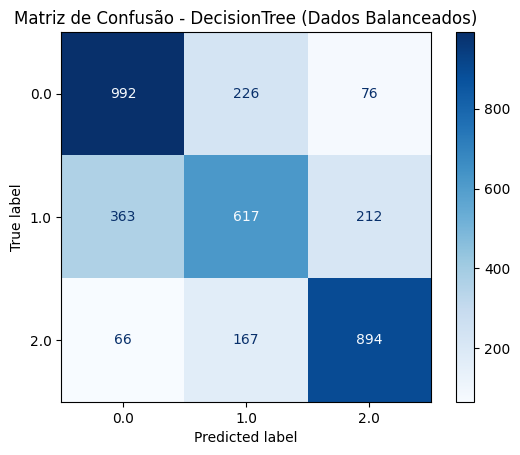

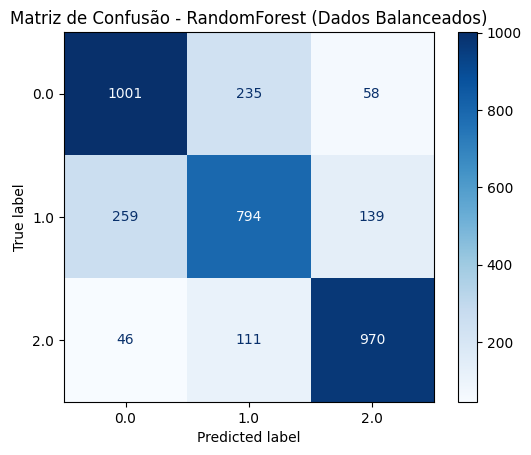

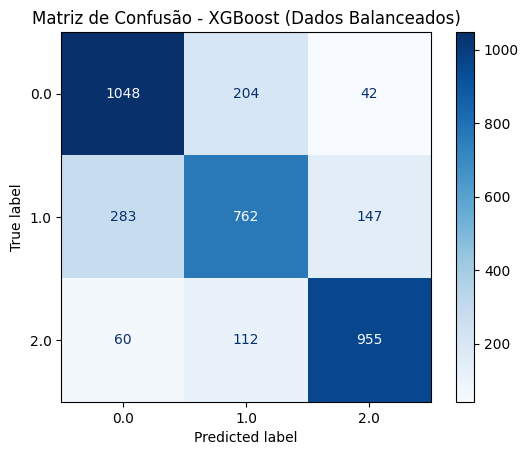

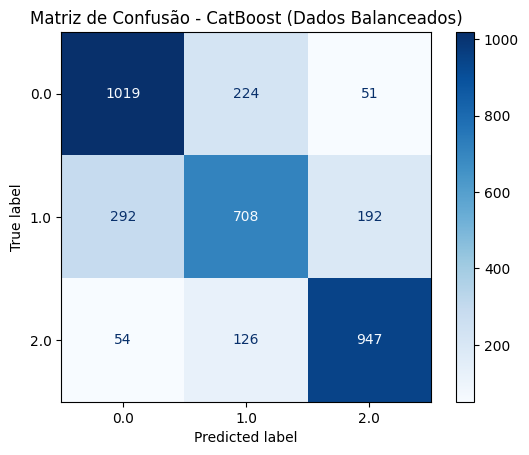

In [54]:
# Parte 5: Gerar matriz de confusão para cada modelo usando dados balanceados
for model_name, model in best_models_balanced.items():
    y_pred = model.predict(X_balanced_test)  # Usar os dados de teste balanceados

    # Gerar a matriz de confusão
    ConfusionMatrixDisplay.from_estimator(model, X_balanced_test, y_balanced_test, cmap='Blues')
    plt.title(f'Matriz de Confusão - {model_name} (Dados Balanceados)')
    plt.show()

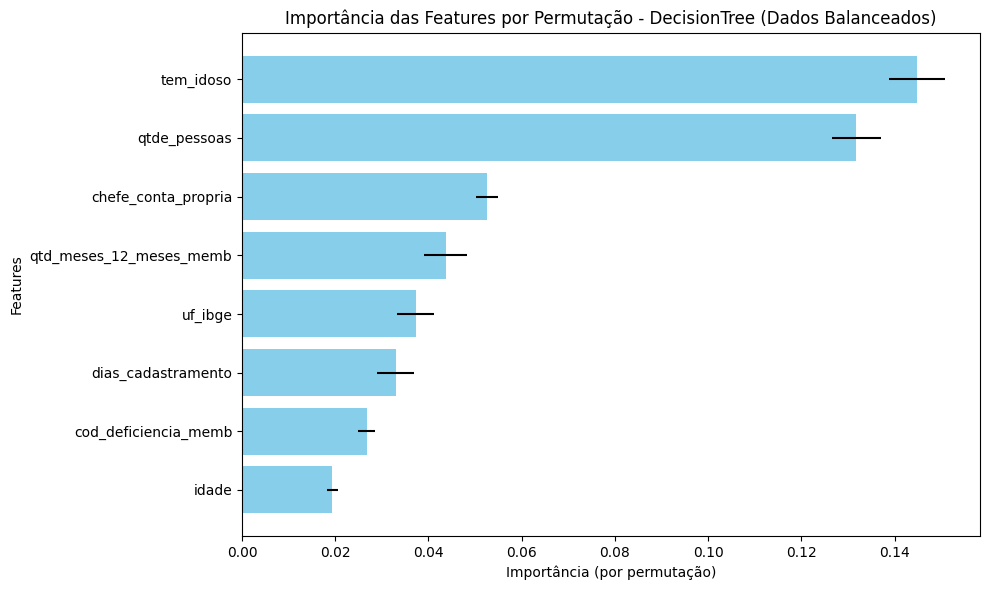

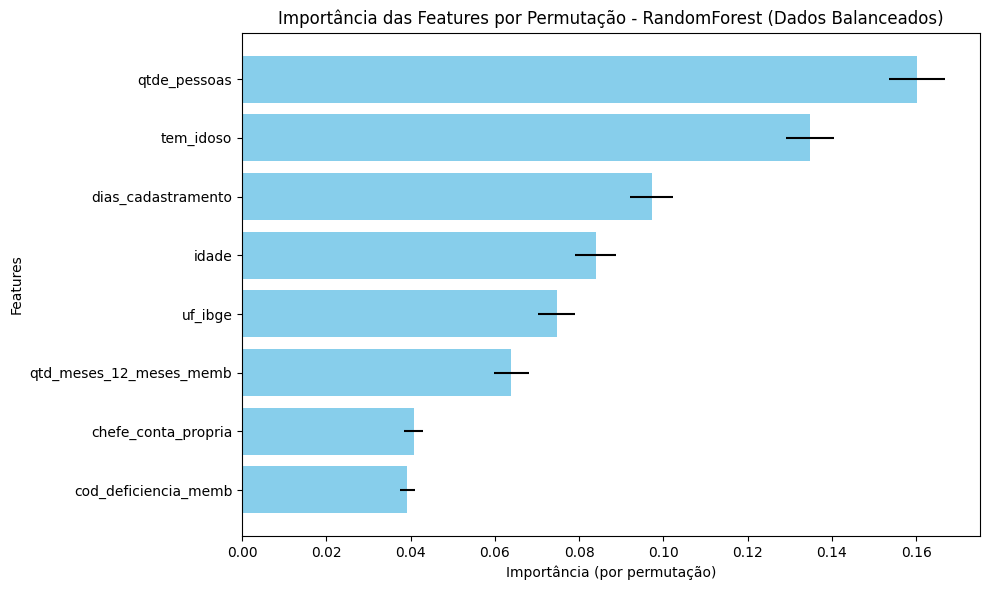

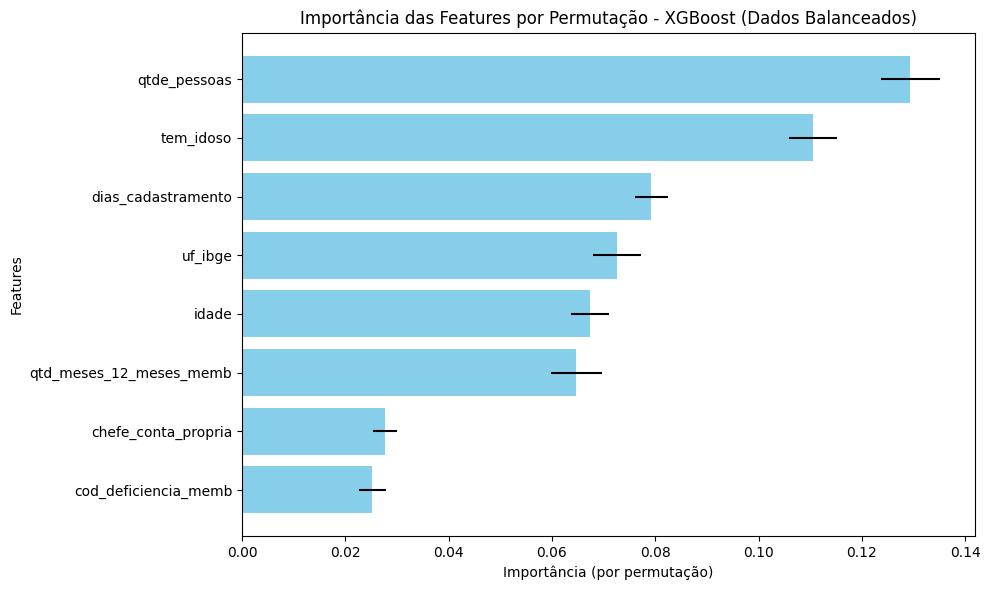

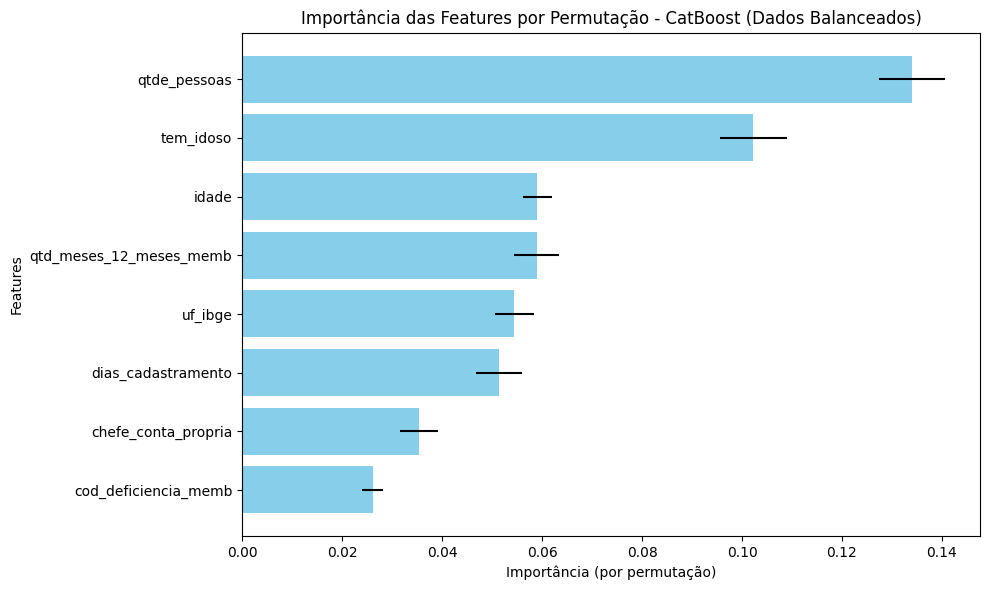

In [55]:
# Parte 6: Importância das features para cada modelo usando dados balanceados
for model_name, model in best_models_balanced.items():
    perm_importance = permutation_importance(model, X_balanced_test, y_balanced_test, n_repeats=10, random_state=42)

    # Ordenar importâncias
    importance_vals = perm_importance.importances_mean
    importance_std = perm_importance.importances_std
    indices = np.argsort(importance_vals)[::-1]

    # Plotar
    plt.figure(figsize=(10, 6))
    plt.title(f"Importância das Features por Permutação - {model_name} (Dados Balanceados)")
    plt.barh(range(len(importance_vals)), importance_vals[indices], xerr=importance_std[indices], align="center", color='skyblue')
    plt.yticks(range(len(importance_vals)), X_balanced_test.columns[indices])
    plt.gca().invert_yaxis()
    plt.xlabel('Importância (por permutação)')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()



In [56]:
# Parte 7: Lista para armazenar as 5 principais features de cada modelo
top_features_list = {}

# Obter as 5 features mais importantes de cada modelo usando dados balanceados
for model_name, model in best_models_balanced.items():
    perm_importance = permutation_importance(model, X_balanced_test, y_balanced_test, n_repeats=10, random_state=42)

    # Extrair valores de importância e índices
    importance_vals = perm_importance.importances_mean
    indices = np.argsort(importance_vals)[::-1]

    # Obter as 5 principais features e suas importâncias
    top_indices = indices[:5]
    top_features = X_balanced_test.columns[top_indices]
    top_importances = importance_vals[top_indices]

    # Armazenar em um DataFrame
    top_features_df = pd.DataFrame({
        'Feature': top_features,
        'Importância': top_importances
    })

    # Adicionar ao dicionário
    top_features_list[model_name] = top_features_df

# Exibir as 5 principais features de cada modelo
for model_name, top_features_df in top_features_list.items():
    print(f"\n5 Features mais importantes para o modelo {model_name} (Dados Balanceados):")
    print(top_features_df)



5 Features mais importantes para o modelo DecisionTree (Dados Balanceados):
                   Feature  Importância
0                tem_idoso     0.144838
1             qtde_pessoas     0.131830
2      chefe_conta_propria     0.052560
3  qtd_meses_12_meses_memb     0.043703
4                  uf_ibge     0.037227

5 Features mais importantes para o modelo RandomForest (Dados Balanceados):
              Feature  Importância
0        qtde_pessoas     0.160144
1           tem_idoso     0.134846
2  dias_cadastramento     0.097260
3               idade     0.083919
4             uf_ibge     0.074675

5 Features mais importantes para o modelo XGBoost (Dados Balanceados):
              Feature  Importância
0        qtde_pessoas     0.129366
1           tem_idoso     0.110518
2  dias_cadastramento     0.079242
3             uf_ibge     0.072544
4               idade     0.067423

5 Features mais importantes para o modelo CatBoost (Dados Balanceados):
                   Feature  Importância
0

# Comparando a performance antes e após o balanceamento

In [57]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.inspection import permutation_importance

In [58]:
# Lista para armazenar as métricas de desempenho
performance_comparison = []

# Avaliar modelos antes do balanceamento
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)

    # Calcular F1 Score e Acurácia
    f1_before = f1_score(y_test, y_pred, average='macro')
    accuracy_before = accuracy_score(y_test, y_pred)

    # Armazenar os resultados antes do balanceamento
    performance_comparison.append({
        'Modelo': model_name,
        'F1 Score Antes do Balanceamento': f1_before,
        'Acurácia Antes do Balanceamento': accuracy_before,
        'F1 Score Após o Balanceamento': None,  # Inicializa como None
        'Acurácia Após o Balanceamento': None,  # Inicializa como None
    })


In [59]:
# Avaliar modelos após o balanceamento
for model_name, model in best_models_balanced.items():
    y_pred_balanced = model.predict(X_balanced_test)

    # Calcular F1 Score e Acurácia
    f1_balanced = f1_score(y_balanced_test, y_pred_balanced, average='macro')
    accuracy_after = accuracy_score(y_balanced_test, y_pred_balanced)

    # Adicionar os resultados após o balanceamento ao mesmo dicionário
    for entry in performance_comparison:
        if entry['Modelo'] == model_name:
            entry['F1 Score Após o Balanceamento'] = f1_balanced
            entry['Acurácia Após o Balanceamento'] = accuracy_after



In [60]:
# Criar DataFrame para as métricas de desempenho
performance_df = pd.DataFrame(performance_comparison)

# Exibir o DataFrame de desempenho
performance_df.head(10)


,Modelo,F1 Score Antes do Balanceamento,Acurácia Antes do Balanceamento,F1 Score Após o Balanceamento,Acurácia Após o Balanceamento
0,DecisionTree,0.596632,0.7390,0.688505,0.692776
1,RandomForest,0.609954,0.7245,0.765548,0.765292
2,XGBoost,0.629696,0.7505,0.764346,0.765292
3,CatBoost,0.631456,0.7495,0.737741,0.740105


In [61]:
# Obter as 5 features mais importantes antes do balanceamento
top_features_before = {}

for model_name, model in best_models.items():
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    importance_vals = perm_importance.importances_mean
    indices = np.argsort(importance_vals)[::-1]

    top_indices = indices[:5]
    top_features = X_test.columns[top_indices]
    top_importances = importance_vals[top_indices]

    top_features_df = pd.DataFrame({
        'Feature': top_features,
        'Importância': top_importances
    })

    top_features_before[model_name] = top_features_df



In [62]:
# Obter as 5 features mais importantes após o balanceamento
top_features_after = {}

for model_name, model in best_models_balanced.items():
    # Calcular a importância das features usando o conjunto de dados balanceado
    perm_importance = permutation_importance(model, X_balanced_test, y_balanced_test, n_repeats=10, random_state=42)

    # Extrair os valores de importância
    importance_vals = perm_importance.importances_mean
    indices = np.argsort(importance_vals)[::-1]

    # Selecionar os 5 índices mais importantes
    top_indices = indices[:5]
    top_features = X_balanced_test.columns[top_indices]
    top_importances = importance_vals[top_indices]

    # Criar DataFrame para armazenar as features e suas importâncias
    top_features_df = pd.DataFrame({
        'Feature': top_features,
        'Importância': top_importances
    })

    # Armazenar o DataFrame na lista de modelos
    top_features_after[model_name] = top_features_df




In [63]:
# Criar DataFrame para as features mais importantes antes e após o balanceamento
top_features_before_df = pd.concat(top_features_before, names=['Modelo', 'Índice']).reset_index()
top_features_after_df = pd.concat(top_features_after, names=['Modelo', 'Índice']).reset_index()

In [64]:
top_features_before_df.head(20)

,Modelo,Índice,Feature,Importância
0,DecisionTree,0,tem_idoso,0.11115
1,DecisionTree,1,qtd_meses_12_meses_memb,0.03790
2,DecisionTree,2,qtde_pessoas,0.03670
3,DecisionTree,3,cod_deficiencia_memb,0.01615
4,DecisionTree,4,chefe_conta_propria,0.01015
5,RandomForest,0,tem_idoso,0.06280
6,RandomForest,1,idade,0.04335
7,RandomForest,2,qtd_meses_12_meses_memb,0.03870
8,RandomForest,3,qtde_pessoas,0.03865
9,RandomForest,4,chefe_conta_propria,0.01810


In [65]:
top_features_after_df.head(20)

,Modelo,Índice,Feature,Importância
0,DecisionTree,0,tem_idoso,0.144838
1,DecisionTree,1,qtde_pessoas,0.131830
2,DecisionTree,2,chefe_conta_propria,0.052560
3,DecisionTree,3,qtd_meses_12_meses_memb,0.043703
4,DecisionTree,4,uf_ibge,0.037227
5,RandomForest,0,qtde_pessoas,0.160144
6,RandomForest,1,tem_idoso,0.134846
7,RandomForest,2,dias_cadastramento,0.097260
8,RandomForest,3,idade,0.083919
9,RandomForest,4,uf_ibge,0.074675


In [66]:
# Combinar em um único dataframe

# Criar um DataFrame vazio para armazenar o resultado
combined_df = pd.DataFrame()

# Iterar sobre os modelos únicos
for modelo in top_features_before_df['Modelo'].unique():
    # Obter as 5 features mais importantes antes e após o balanceamento
    antes = top_features_before_df[top_features_before_df['Modelo'] == modelo].reset_index(drop=True)
    depois = top_features_after_df[top_features_after_df['Modelo'] == modelo].reset_index(drop=True)

    # Adicionar as features antes e depois ao DataFrame combinado
    for i in range(5):  # Para as 5 features mais importantes
        combined_df = pd.concat([combined_df, pd.DataFrame({
            'Modelo': modelo,
            'Feature Antes': antes['Feature'][i],
            'Importância Antes': antes['Importância'][i],
            'Feature Após': depois['Feature'][i],
            'Importância Após': depois['Importância'][i]
        }, index=[0])], ignore_index=True)


In [67]:
 combined_df.head(20)

,Modelo,Feature Antes,Importância Antes,Feature Após,Importância Após
0,DecisionTree,tem_idoso,0.11115,tem_idoso,0.144838
1,DecisionTree,qtd_meses_12_meses_memb,0.03790,qtde_pessoas,0.131830
2,DecisionTree,qtde_pessoas,0.03670,chefe_conta_propria,0.052560
3,DecisionTree,cod_deficiencia_memb,0.01615,qtd_meses_12_meses_memb,0.043703
4,DecisionTree,chefe_conta_propria,0.01015,uf_ibge,0.037227
5,RandomForest,tem_idoso,0.06280,qtde_pessoas,0.160144
6,RandomForest,idade,0.04335,tem_idoso,0.134846
7,RandomForest,qtd_meses_12_meses_memb,0.03870,dias_cadastramento,0.097260
8,RandomForest,qtde_pessoas,0.03865,idade,0.083919
9,RandomForest,chefe_conta_propria,0.01810,uf_ibge,0.074675
